In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install import-ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks/RetinaSmartCamera/notebooks

Mounted at /content/drive
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=cce077710e8ee2c8d61edea07ba5b2f11325f8deeffcca360850dc779ba80213
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/notebooks


In [ ]:
#Import dataloader
import import_ipynb
import DataLoaders
from DataLoaders import get_dataloader

#Standard imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import re
import os

importing Jupyter notebook from DataLoaders.ipynb
importing Jupyter notebook from RetinaUtils.ipynb


Slightly modified version of Meng Dong's PCN, as his version was giving me warnings and for more clarity

In [ ]:
class PCN(nn.Module):
    class PcConv(nn.Module):
        def __init__(self, inchan, outchan, kernel_size=3, circles=0):
            super().__init__()
            #Number of Feedforward-Feedbackward repetitions
            self.circles = circles
            self.relu = nn.ReLU(inplace=True)
            #Feedforward layer
            self.FFconv = nn.Conv2d(inchan, outchan, kernel_size, stride=1, padding=1, bias=False)
            #Feedbackward layer
            self.FBconv = nn.ConvTranspose2d(outchan, inchan, kernel_size, stride=1, padding=1, bias=False)
            #Recurrent layer
            self.bypass = nn.Conv2d(inchan, outchan, kernel_size=1, stride=1, bias=False)
            #Parameter used to determine the weights of the Feedforwad-Feedbackward layers
            self.alpha = nn.Parameter(torch.zeros(1, outchan, 1, 1))

        def forward(self, x):
            y = self.relu(self.FFconv(x))
            alpha = F.relu(self.alpha[0]+1.0).expand_as(y)
            for _ in range(self.circles):
                y = self.FFconv(self.relu(x - self.FBconv(y)))*alpha + y
            y = y + self.bypass(x)
            return y

    def __init__(self, num_classes, circles=4):
        super().__init__()
        #Predictive Coding blocks
        self.PC_block1 = nn.Sequential(nn.BatchNorm2d(3),
                                       self.PcConv(3,64, circles=circles))
        self.PC_block2 = nn.Sequential(nn.BatchNorm2d(64),
                                       self.PcConv(64,64, circles=circles))
        self.PC_block3 = nn.Sequential(nn.BatchNorm2d(64),
                                       self.PcConv(64, 128, circles=circles),
                                       nn.MaxPool2d(kernel_size=2, stride=2))
        #Final BatchNorm and ReLU
        self.final_bn = nn.Sequential(nn.BatchNorm2d(128),
                                      nn.ReLU(True))
        #Fully connected layer
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.PC_block1(x)
        x = self.PC_block2(x)
        x = self.PC_block3(x)
        x = self.final_bn(x)
        
        #Downsample to flatten last dimensions
        out = F.avg_pool2d(x, x.size(-1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        #Return predictions
        return out

In [ ]:
#Get cortical images from my dataset
dataloader = get_dataloader(image_type='original_corticalimages', personal=True, skip=2, batch_size=8)

cuda:0
Iterating over Background
Number of images for class  Background :  162
Number of images for class  Background :  172
Iterating over Charger
Number of images for class  Charger :  196
Number of images for class  Charger :  188
Iterating over Coin
Number of images for class  Coin :  164
Number of images for class  Coin :  167
Iterating over Gargoyle
Number of images for class  Gargoyle :  185
Number of images for class  Gargoyle :  179
Iterating over Glasses
Number of images for class  Glasses :  175
Number of images for class  Glasses :  170
Iterating over Jellyfish
Number of images for class  Jellyfish :  192
Number of images for class  Jellyfish :  184
Iterating over Key
Number of images for class  Key :  173
Number of images for class  Key :  164
Iterating over Laptop
Number of images for class  Laptop :  184
Number of images for class  Laptop :  192
Iterating over Pens
Number of images for class  Pens :  172
Number of images for class  Pens :  179
Iterating over Remote
Numbe

In [ ]:
import itertools
#Function used to plot confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Classes for the confusion matrix
classes = ['Background', 'Charger', 'Coin', 'Gargoyle', 'Glasses', 'Jellyfish',
            'Key', 'Laptop', 'Pens', 'Remote', 'Wallet']

In [ ]:
#Train model
def train(model, optimiser, criterion, dataset, resize):
    model.train()
    train_loss = 0
    #Iterate over data
    for i, data in enumerate(dataset):
        if i%200==0:
            print('Iteration %d'%i)
        #Resize images 
        image, label = data
        image, label = resize(image).to(device), label.to(device)
        optimiser.zero_grad()
        #Get predictions
        output = model(image)
        #Compare predicitons to ground truth
        loss = criterion(output, label)
        loss.backward()
        optimiser.step()

        #Update running loss
        train_loss += loss.data.item()*image.size(0)
    return train_loss

#Evaluate model
def eval(model, dataset, resize):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataset:
            image, label = data
            image, label = resize(image).to(device), label.to(device)
            #Get predictions
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            #Get total
            total += label.size(0)
            #Get correct predictions
            correct += (predicted == label).sum().item()
    #Return accuracy
    return 100.0 * correct/total 

def run_model(model, dataset, optimiser, criterion, model_name, epochs, log_dir):
    #Load the Tensorboard summary writer
    writer = SummaryWriter(log_dir=log_dir)
    resize = transforms.Resize((64,64))

    #Split the dataloader. Here we are also evaluating the train set as the ground truth
    train_set = dataset['train']
    val_set = dataset['train']
    test_set = dataset['test']

    #Train and evaluate
    for epoch in range(1, epochs+1):
        #Reduce learning rate
        if epoch in [200, 250]:
            for param_group in optimiser.param_groups:
                param_group['lr'] /= 10

        #Print and log training loss
        print('----------Epoch %d----------'%epoch)
        train_loss = train(model, optimiser, criterion, train_set, resize)
        print('Train loss: ', train_loss/len(train_set))
        writer.add_scalars(main_tag='Training Loss', global_step=epoch, tag_scalar_dict={
            'Training loss' : train_loss/len(train_set)})

        #Evaluate the model
        if epoch%5 == 0:
            #See how well the model is doing with the Train set
            validation_accuracy = eval(model, val_set, resize)
            writer.add_scalars(main_tag='Validation Accuracy', global_step=epoch, tag_scalar_dict={
            'Validation Accuracy' : validation_accuracy
            })
            print('Validation Accuracy: ', validation_accuracy)
            
            #Evaluate accuracy with the test set
            test_accuracy = eval(model, test_set, resize)
            writer.add_scalars(main_tag='Test Accuracy', global_step=epoch, tag_scalar_dict={
            'Test Accuracy' : test_accuracy
            })
            print('Test Accuracy: ', test_accuracy)
    #Close writer and save model
    writer.close()
    torch.save({'model_state_dict': model.state_dict()}, 
               '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/final_'+model_name+'.pt')
    
    #Finally, plot the confusion matrix of the test set
    confusion_matrix = torch.zeros((11,11))
    correct, total = (0,0)
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_set):
            images = resize(images).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            for t,p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print(100.0*correct/total)
    plot_confusion_matrix(confusion_matrix.numpy().astype(int), classes)

In [ ]:
#Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PCN(20, circles=4).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.001, weight_decay=1e-3, nesterov=False)

run_model(model, dataloader, optimiser, criterion, 'PCN_personal_train_test', 100, 'log/pcn_train_test')

----------Epoch 1----------
Iteration 0
Iteration 200
Train loss:  17.579557491852356
----------Epoch 2----------
Iteration 0
Iteration 200
Train loss:  11.856074215055585
----------Epoch 3----------
Iteration 0
Iteration 200
Train loss:  8.755464581755904
----------Epoch 4----------
Iteration 0
Iteration 200
Train loss:  7.590047816972475
----------Epoch 5----------
Iteration 0
Iteration 200
Train loss:  6.262458593995722
Validation Accuracy:  84.62837837837837
Test Accuracy:  57.296380090497735
----------Epoch 6----------
Iteration 0
Iteration 200
Train loss:  5.27086325056918
----------Epoch 7----------
Iteration 0
Iteration 200
Train loss:  4.7170269559095575
----------Epoch 8----------
Iteration 0
Iteration 200
Train loss:  4.284890535983953
----------Epoch 9----------
Iteration 0
Iteration 200
Train loss:  3.817238951051557
----------Epoch 10----------
Iteration 0
Iteration 200
Train loss:  3.103693978475021
Validation Accuracy:  98.08558558558559
Test Accuracy:  69.2307692307692

Confusion matrix, without normalization


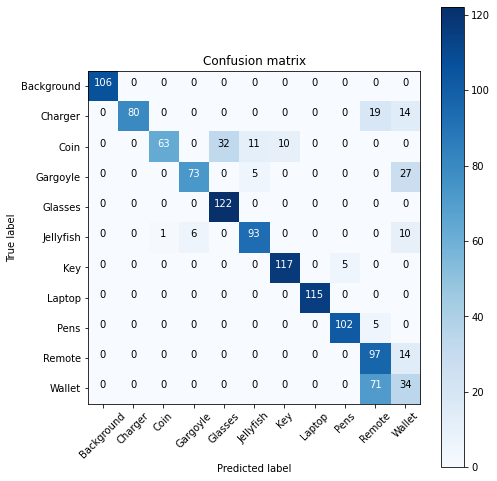

In [ ]:
#Plot confusion matrix
resize = transforms.Resize((64, 64))
confusion_matrix = torch.zeros((11,11))
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloader['test']):
        images = resize(images).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        for t,p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
classes = ['Background', 'Charger', 'Coin', 'Gargoyle', 'Glasses', 'Jellyfish',
            'Key', 'Laptop', 'Pens', 'Remote', 'Wallet']
plot_confusion_matrix(confusion_matrix.numpy().astype(int), classes)